In [1]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
from random import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import cv2
import random

def getName(filePath):
    return filePath.split("/")[-1]
 
def importDataInfo(path):
    columns = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']
    data = pd.read_csv(os.path.join(path, 'driving_log.csv'), names = columns)
    #### REMOVE FILE PATH AND GET ONLY FILE NAME
    #print(getName(data['center'][0]))
    data['Center']=data['Center'].apply(getName)
    #print(data.head())
    print('Total Images Imported',data.shape[0])
    return data

def balanceData(data,display=True):
    nBin = 31
    samplesPerBin = 500
    hist, bins = np.histogram(data['Steering'], nBin)
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()
        removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j + 1]:
                binDataList.append(i)
        shuffle(binDataList)
        binDataList = binDataList[:samplesPerBin]
        removeindexList.extend(binDataList)
 
    print('Removed Images:', len(removeindexList))
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))
    return data

def loadData(path, data):
  imagesPath = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    imagesPath.append(f'{indexed_data[0]}')
    steering.append(float(indexed_data[3]))
  imagesPath = np.asarray(imagesPath)
  steering = np.asarray(steering)
  return imagesPath, steering

def augmentImage(imgPath,steering):
    img =  mpimg.imread(imgPath)
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.2, 1.2))
        img = brightness.augment_image(img)
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = -steering
    return img, steering

def preProcess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img
def batchGen(imagesPath, steeringList, batchSize, trainFlag):
    while True:
        imgBatch = []
        steeringBatch = []
        for i in range(batchSize):
            index = random.randint(0, len(imagesPath) - 1)
            if trainFlag:
               img, steering = augmentImage(imagesPath[index], steeringList[index])
               img = preProcess(img)
               imgBatch.append(img)
               steeringBatch.append(steering)
            else:
                img = mpimg.imread(imagesPath[index])
                steering = steeringList[index]
                img = preProcess(img)
                imgBatch.append(img)
                steeringBatch.append(steering)
        yield (np.asarray(imgBatch),np.asarray(steeringBatch))

Total Images Imported 2248


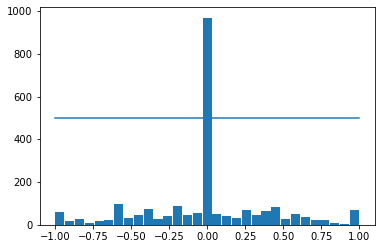

Removed Images: 1779
Remaining Images: 469
Total Training Images:  375
Total Validation Images:  94
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                      

C:\Users\prashant.goswami\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
30/30 [==============================] - 48s 2s/step - loss: 0.0065 - val_loss: 4.3699e-04
Epoch 2/10
30/30 [==============================] - 45s 2s/step - loss: 4.0897e-04 - val_loss: 3.2814e-04
Epoch 3/10
30/30 [==============================] - 45s 2s/step - loss: 2.1502e-04 - val_loss: 2.7325e-04
Epoch 4/10
30/30 [==============================] - 44s 2s/step - loss: 1.7927e-04 - val_loss: 2.6393e-04
Epoch 5/10
30/30 [==============================] - 44s 2s/step - loss: 1.6636e-04 - val_loss: 2.2506e-04
Epoch 6/10
30/30 [==============================] - 44s 2s/step - loss: 1.3029e-04 - val_loss: 2.2114e-04
Epoch 7/10
30/30 [==============================] - 75s 3s/step - loss: 1.1804e-04 - val_loss: 1.9888e-04
Epoch 8/10
30/30 [==============================] - 43s 1s/step - loss: 1.1719e-04 - val_loss: 1.9740e-04
Epoch 9/10
30/30 [==============================] - 41s 1s/step - loss: 1.0604e-04 - val_loss: 1.7486e-04
Epoch 10/10
30/30 [==============================]

In [2]:
from model import createModel
path = '../data2'
data = importDataInfo(path)
data = balanceData(data,display=True)
imagesPath, steerings = loadData(path,data)
xTrain, xVal, yTrain, yVal = train_test_split(imagesPath, steerings, test_size=0.2,random_state=10)
print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))      

model = createModel()
model.summary()

history = model.fit(batchGen(xTrain, yTrain, 100, 1),
                                  steps_per_epoch=30,
                                  epochs=10,
                                  validation_data=batchGen(xVal, yVal, 100, 0),
                                  validation_steps=20)

Model Saved


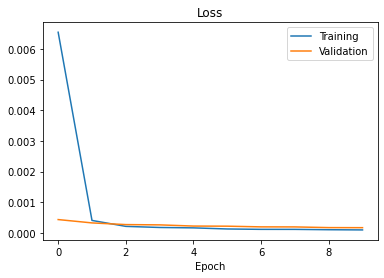

In [3]:
model.save('model.h5')
print('Model Saved')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import socketio
import eventlet
import numpy as np
from flask import Flask
from tensorflow.keras.models import load_model
import base64
from io import BytesIO
from PIL import Image
import cv2
 
#### FOR REAL TIME COMMUNICATION BETWEEN CLIENT AND SERVER
sio = socketio.Server()
#### FLASK IS A MICRO WEB FRAMEWORK WRITTEN IN PYTHON
app = Flask(__name__)  # '__main__'
 
maxSpeed = 10
 
 
def preProcess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img
 
 
@sio.on('telemetry')
def telemetry(sid, data):
    speed = float(data['speed'])
    image = Image.open(BytesIO(base64.b64decode(data['image'])))
    image = np.asarray(image)
    image = preProcess(image)
    image = np.array([image])
    steering = float(model.predict(image))
    throttle = 1.0 - speed / maxSpeed
    print(f'{steering}, {throttle}, {speed}')
    sendControl(steering, throttle)
 
 
@sio.on('connect')
def connect(sid, environ):
    print('Connected')
    sendControl(0, 0)
 
 
def sendControl(steering, throttle):
    sio.emit('steer', data={
        'steering_angle': steering.__str__(),
        'throttle': throttle.__str__()
    })
 
 
if __name__ == '__main__':
    model = load_model('model.h5')
    app = socketio.Middleware(sio, app)
    ### LISTEN TO PORT 4567
    eventlet.wsgi.server(eventlet.listen(('', 4567)), app)

ModuleNotFoundError: No module named 'socketio'

In [9]:
!pip install eventlet